In [234]:
!pip install fasttext
!pip install Pillow
!pip install matplotlib
!pip install "tensorflow_hub==0.4.0"

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import fasttext as ft

In [235]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
results_csv_path = '/content/drive/Shared drives/Deep Six Design/Deep Six Design/Projects/Neural Art Process/alexgrey_images/results.csv'
results_txt_path = '/content/drive/Shared drives/Deep Six Design/Deep Six Design/Projects/Neural Art Process/alexgrey_images/results.txt'
images_path = '/content/drive/Shared drives/Deep Six Design/Deep Six Design/Projects/Neural Art Process/alexgrey_images/alexgrey_images/'
test_image_path = '/content/drive/Shared drives/Deep Six Design/Deep Six Design/Projects/Neural Art Process/alexgrey_images/alexgrey_images/00000000.jpg'

Mounted at /content/drive


In [0]:
# read image descriptions
image_descriptions = pd.read_csv(results_csv_path, sep='\|\s', engine='python')
selected_columns = ['image_name', 'comment']
image_descriptions = image_descriptions[selected_columns]

In [0]:
# create a language model quickly with fasttext
fasttext_model = ft.train_unsupervised(model='skipgram', input=results_txt_path)
# save model
fasttext_model.save_model("ftxt_model.bin")

In [238]:
# load saved model
fasttext_model = ft.load_model("ftxt_model.bin")

In [239]:
# convert string to embeddings
fasttext_model.get_sentence_vector('alex grey is painting')

array([ 0.04485995,  0.01385641, -0.08458335, -0.04492927, -0.05817111,
       -0.00196221, -0.05164709,  0.05775929, -0.10308609,  0.04050362,
       -0.00385605,  0.07155341,  0.00088483, -0.01075763,  0.00833723,
       -0.00087484, -0.06080544, -0.05481864,  0.01551671, -0.00472979,
       -0.03327279, -0.00864858, -0.01938952, -0.05849255,  0.0500612 ,
        0.04482729, -0.00824623,  0.03904291,  0.00114138, -0.0391383 ,
       -0.03616477,  0.00903169, -0.07866518, -0.05840334, -0.03170545,
        0.03908821,  0.02580474, -0.09488712,  0.05143586,  0.02567422,
        0.0546964 ,  0.05099497, -0.10378416, -0.07169448, -0.0167801 ,
       -0.06116953,  0.01145604, -0.07374774, -0.02721379, -0.10451512,
        0.07203234, -0.1177737 , -0.0450815 ,  0.10129648,  0.05844605,
        0.03577279, -0.02344843, -0.04329304,  0.04988667, -0.02623431,
        0.08945175, -0.04688323, -0.04010647, -0.07226645, -0.04485809,
        0.04817876, -0.11448543, -0.01422044, -0.02453003,  0.03

In [240]:
def concater(x):
    try:
        return ' '.join(x)
    except Exception as e:
        return ''

# concatenate strings for same images
image_descriptions['comment'] = image_descriptions.groupby(['image_name'])['comment'].transform(concater)
image_descriptions = image_descriptions[['image_name','comment']].drop_duplicates()
image_descriptions.head(4)

,image_name,comment
0,00000000.jpg,Tears of Joy . Alex Grey .
2,00000001.jpg,The One . Alex Grey .
4,00000002.jpg,White Light . Alex Grey .


In [0]:
# load mobilenet featurevector model as a Keras layer
module = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
        output_shape=[1280],
        trainable=False)
])

# build the model
module.build([None, 224, 224, 3])

# This model will only accept images of size 224 x 224
# So, we need to make sure throughout the code, that we supply correcty resized images
im_height, im_width = 224, 224

In [0]:
# Here is the helper function to load and resize image
def load_rsize_image(filename, w, h):
    # open the image file
    im = Image.open(filename)
    # resize the image
    im = im.resize(size=(w, h))
    return np.asarray(im)

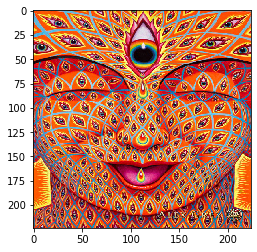

In [243]:
# Let's test loading an image
image_array = load_rsize_image(test_image_path, im_width, im_height)
plt.imshow(image_array)

In [0]:
# helper function to retrieve fasttext word embeddings
def get_ftxt_embeddings(text):
    return fasttext_model.get_sentence_vector(text)

# helper function to encode images with mobilenet
def get_image_encodings(batch, module):
    message_embeddings = module.predict(batch)
    return message_embeddings

In [0]:
# helper function to embed images and comments in a dataframe and return numpy metrices
# this function will iterate through a dataframe, which contains image file names in one column and 
# comments in another column and will generate seperate matrices for images and comments.
# row order of these matrices matters because same row index in both matrices represent related image and comments.
def embed_all(df, w, h):
    img_arr = []
    txt_arr = []
    # for each row, embed data
    for index, row in df.iterrows():
        # img_arr will contain all the image file data (will be passed to mobilenet later)
        img_arr.append(load_rsize_image(images_path + row['image_name'], w, h))
        # txt_arr will contain all Fasttext sentance embedding for each comment 
        txt_arr.append(get_ftxt_embeddings(row['comment']))
    return img_arr, txt_arr

In [0]:
img_emb, txt_emb = embed_all(image_descriptions, im_width, im_height)
# reset fasttext model
fasttext_model = None

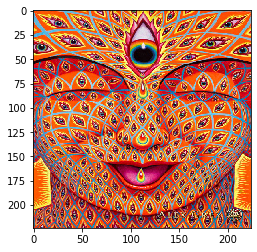

In [247]:
# verify that image is image loded correctly
plt.imshow(img_emb[0])

In [248]:
# test image encodings generation
get_image_encodings(np.true_divide(np.array(img_emb[0:100]), 255), module).shape

(3, 1280)

In [249]:
# install AquilaDb python client

! pip install aquiladb

# import AquilaDB client
from aquiladb import AquilaClient as acl

In [0]:
# create DB instance.
# Please provide the IP address of the machine that have AquilaDB installed in.
db = acl('http://35.232.80.141/', 50051)

# let's get our hands dirty for a moment..
# convert a sample dirty Document
sample = db.convertDocument([0.1,0.2,0.3,0.4], {"alex": "grey"})

In [251]:
# and print it
sample

{'b64data': b'{"alex":"grey"}', 'vector': {'e': [0.1, 0.2, 0.3, 0.4]}}

In [252]:
# batch length - to be sent to mobilenet for encoding
blen = 3
# which index to start encoding - ofcause its 0
vstart = 0
# How much images/text we need to encode
vend = 3

# convert text embeddings to numpy array
txt_emb = np.array(txt_emb)

# iterate over each batch of image/text data/embedding
for ndx in range(vstart, vend, blen):
    # encode each batch of images
    image_encoding = get_image_encodings(np.true_divide(np.array(img_emb[ndx:ndx+blen]), 255), module)
    
    # pad image and text vectors - this is discussed in section `filter based indexing`
    # select subset of data we're interested for text embeddings
    text_embedding = txt_emb[ndx:ndx+blen]
    # pad text encodings with trailing zeros
    text_embedding = np.pad(text_embedding, ((0, 0), (0, 1280)), 'constant')
    # pad image encodings with preceding zeros
    image_encoding = np.pad(image_encoding, ((0, 0), (100, 0)), 'constant')
    
    # finally, create and send each document
    for i in range(blen):
        # create document - text
        doc_txt = db.convertDocument(text_embedding[i], {"image_name": image_descriptions.iloc[ndx+i][0]})
        # create document - image
        doc_img = db.convertDocument(image_encoding[i], {"image_name": image_descriptions.iloc[ndx+i][0]})
        
        # send documents - text
        db.addDocuments([doc_txt])
        # send documents - image
        db.addDocuments([doc_img])
    
    # Wooh! done with nth batch   
    print('Done: ', ndx, ndx+blen)

_Rendezvous: ignored

#### search images by text

In [0]:
import json 

# search by text
def search_by_text(text_in):
    # load saved model
    fasttext_model = ft.load_model("ftxt_model.bin")
    # generate embeddings
    text_embedding_ = fasttext_model.get_sentence_vector(text_in)
    # pad text embedding
    text_embedding_ = np.pad([text_embedding_], ((0, 0), (0, 1280)), 'constant')

    # convert query matrix
    q_matrix = db.convertMatrix(np.asarray(text_embedding_[0]))
    # do k-NN search
    k = 10
    result = db.getNearest(q_matrix, k)
    return json.loads(result.documents)

# render images
def render_images(doclist):
    for doc in doclist:
        filename = doc["doc"]["image_name"]
        im = Image.open(images_path + filename)
        fig = plt.figure()
        plt.imshow(im)

#### text to image search 1

In [0]:
render_images(search_by_text('grey'))

#### search images by image

In [0]:
# search by image
def search_by_image(image_in, w, h, module):
    # load image
    q_image = load_rsize_image(images_path + image_in, w, h)
    q_image = np.array([np.asarray(q_image)])
    # generate encodings
    image_encoding_ = get_image_encodings(np.true_divide(q_image, 255), module)
    # pad image encodings
    image_encoding_ = np.pad(image_encoding_, ((0, 0), (100, 0)), 'constant')

    # convert query matrix
    q_matrix = db.convertMatrix(np.asarray(image_encoding_[0]))
    # do k-NN search
    k = 10
    result = db.getNearest(q_matrix, k)
    return json.loads(result.documents)

#### image to image search 1

In [0]:
q_im_file = test_image_path

# show query image
render_images([{"doc":{"image_name": q_im_file}}])

In [0]:
# do search
render_images(search_by_image(q_im_file, im_width, im_height, module))